In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Quantum_Kernel import *
import time

%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit , transpile, Aer ,IBMQ
from qiskit.visualization import *
from qiskit.tools.jupyter import *
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import QasmSimulator

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *

from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit_machine_learning.neural_networks import OpflowQNN
import qiskit.quantum_info as qi
from scipy import optimize
from qiskit.opflow.gradients import Gradient
from typing import Union

from IPython.display import clear_output
from scipy.optimize import approx_fprime
from tqdm import tqdm

In [2]:
# Loading your IBM Quantum account(s)
from qiskit import IBMQ

# IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q-kqc', group='internal', project='default')

In [3]:
def simple_kernel_A(x,repeat=5):
    qc = QuantumCircuit(repeat)
    for i in range(repeat) :
        qc.rx(x[0]*3**i,[i])
    for i in range(repeat-1) :
        qc.cx([i],[i+1])
    qc.cx([repeat-1],[0])
    for i in range(repeat-2) :
        qc.cx([i],[i+2])
    encode = qc
    return [encode,repeat]

In [4]:
n_samples = 200
blobs_params = dict(random_state=0, n_samples=n_samples, n_features=2)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles,make_blobs,make_moons,make_classification

np.random.seed(0)

data0_X,data0_y = make_circles(n_samples=n_samples, factor=.5, noise=.05)
data0_X = data0_X*5
data1_X,data1_y = make_moons(n_samples=n_samples, noise=0.05, random_state=0)
data2_X,data2_y = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1, 1], **blobs_params)
data3_X,data3_y = make_blobs(centers=[[1, 1], [-1, -1]], cluster_std=[1, 1], **blobs_params)
data4_X,data4_y = make_classification(n_samples=n_samples,n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
data4_X += rng.uniform(size=data4_X.shape)

datasets_X = [data0_X,data1_X,data2_X,data3_X,data4_X]
datasets_y = [data0_y,data1_y,data2_y,data3_y,data4_y]


In [5]:
datasets_X_S = []
for i in range(5):
    data_temp = datasets_X[i]
    data_temp_scale = np.pi*(data_temp-np.min(data_temp))/(np.max(data_temp)-np.min(data_temp))
    datasets_X_S += [np.array(data_temp_scale)]

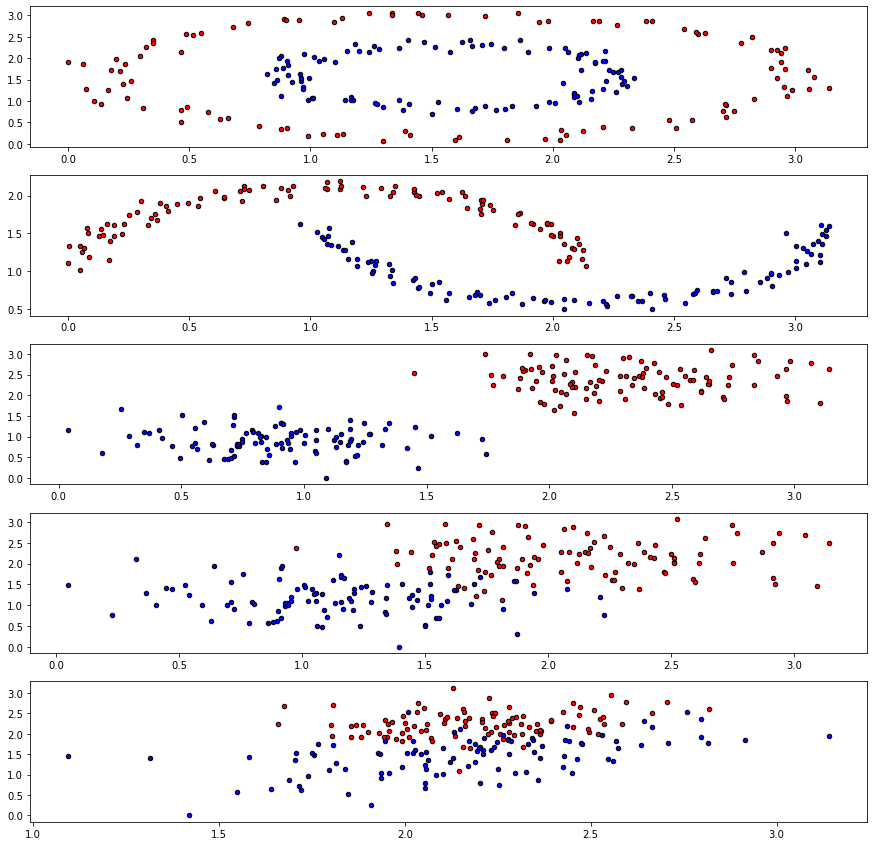

In [6]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1

    plt.subplot(5,1,i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    

In [7]:
def exponential_kernel_B(x,repeat=5):
    qc = QuantumCircuit(repeat)
    for i in range(repeat) :
        qc.rx(x[0]*3**i,[i])
    for i in range(repeat-1) :
        qc.cx([i],[i+1])
    qc.cx([repeat-1],[0])
    for i in range(repeat) :
        qc.ry(x[1]*3**i,[i])
    for i in range(repeat-1) :
        qc.cx([i],[i+1])
    qc.cx([repeat-1],[0])

    encode = qc
    return [encode,repeat]

In [50]:
datasets_y_sto = []
datasets_test_y_sto =[]
sto_index_sets = []
sto_index_test_sets = []
gram_kernel_set= []
gram_kernel_test_set =[]
gram_gaussian_set = []
gram_gaussian_test_set =[]


sample = 20
test_sample = 20
backend = QasmSimulator()

for i in range(5) :
    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    sto_index_sets += [sto_ind]
    
    sto_ind = np.random.randint(0,len(datasets_X_S[i]),test_sample)
    data_sto_test = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_test_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    sto_index_test_sets += [sto_ind]
    n = sample
    m = test_sample


    start_time = time.time()
    gram_matrix = get_gram(data=data_sto,kernel_fun=exponential_kernel_B,layer=3,backend=backend,shots=1000)
    gram_test_matrix = get_gram_test(data=data_sto,test_data = data_sto_test,kernel_fun=exponential_kernel_B,layer=3,backend=backend,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    gram_kernel_set += [gram_matrix]
    gram_kernel_test_set += [gram_test_matrix]

    gram_matrix = Gram_gaussian(data_sto.values,3)
    gram_gaussian_set += [gram_matrix]

    datasets_y_sto += [np.array(data_sto_y)]
    datasets_test_y_sto += [np.array(data_sto_test_y)]
    

  5%|▌         | 5/100 [00:53<16:48, 10.62s/it]

In [ ]:
for i in range(5):
    pd.DataFrame(gram_gaussian_set[i]).to_csv("svm_data/gram_gaussian_"+str(i)+".csv")
    pd.DataFrame(gram_kernel_set[i]).to_csv("svm_data/gram_kernel"+str(i)+".csv")
    pd.DataFrame(gram_kernel_test_set[i]).to_csv("svm_data/gram_kernel_test"+str(i)+".csv")
    pd.DataFrame(datasets_X_S[i]).to_csv("svm_data/datasets_X_S"+str(i)+".csv")
    pd.DataFrame(datasets_y_sto[i]).to_csv("svm_data/datasets_y_sto"+str(i)+".csv")
    pd.DataFrame(datasets_test_y_sto[i]).to_csv("svm_data/datasets_test_y_sto"+str(i)+".csv")
    pd.DataFrame(sto_index_sets[i]).to_csv("svm_data/sto_index_sets"+str(i)+".csv")
    pd.DataFrame(sto_index_test_sets[i]).to_csv("svm_data/sto_index_test_sets"+str(i)+".csv")
    

IndexError: list index out of range

In [ ]:
y_s= (data_sto_y.values.T[0]-0.5)*2
diag_y = np.diag(y_s)

y_s_t= (data_sto_test_y.values.T[0]-0.5)*2
diag_y_t = np.diag(y_s_t)



In [ ]:
c_init = np.random.normal(0,1,yky.shape[0])
c_temp = c_init
lr = 0.0001
for i in range(10000):
    P = 1
    c_temp += - lr*(1-P*y_s-np.matmul(yky,c_temp.T))
b = np.matmul((c_temp * y_s),Gram) - y_s
np.sign(np.matmul((c_temp * y_s),Gram) - b)

array([ 1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1.,  1.,  1., -1.,  1.,  1.])

In [ ]:
y_s

array([ 1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1.,  1.,  1., -1.,  1.,  1.])

In [ ]:
c_init = np.random.normal(0,1,gram_test_matrix.shape[0])
c_temp = c_init
lr = 0.0001
y_s= (data_sto_y.values.T[0]-0.5)*2
diag_y = np.diag(y_s)
kernel_matrix = gram_test_matrix
yky = np.matmul(np.matmul(diag_y,kernel_matrix),diag_y)
for i in range(10000):
    P = 1
    c_temp += - lr*(1-P*y_s-np.matmul(yky,c_temp.T))
b = np.matmul((c_temp * y_s),kernel_matrix) - y_s
np.sign(np.matmul((c_temp * y_s),kernel_matrix) - b)

array([-1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1.,  1., -1.])

In [ ]:
y_s

array([-1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1.,  1., -1.])

In [ ]:
kernel_matrix = gram_kernel_set[4]
c_init = np.random.normal(0,1,gram_matrix.shape[0])
c_temp = c_init
lr = 0.0001
y_s= (data_sto_y.values.T[0]-0.5)*2
diag_y = np.diag(y_s)

yky = np.matmul(np.matmul(diag_y,kernel_matrix),diag_y)
for i in range(10000):
    P = 1
    c_temp += - lr*(1-P*y_s-np.matmul(yky,c_temp.T))
b = np.matmul((c_temp * y_s),kernel_matrix) - y_s
y_pred_train = np.sign(np.matmul((c_temp * y_s),kernel_matrix) - b)
y_pred_test = np.sign(np.matmul((c_temp * y_s),gram_test_matrix) - b)

In [ ]:
1-sum(y_s_t!=y_pred_test)/20

0.65

In [ ]:
1-sum(y_s!=y_pred_train)/20

1.0